In [1]:
f = function (u,p,t)
    q,s,w = p
    [ s*(u[2]-u[1]*u[2]+u[1]-q*u[1]^2);
    (-u[2]-u[1]*u[2]+u[3])/s; 
    w*(u[1]-u[3]) ]
end

#3 (generic function with 1 method)

One of the stiff solvers, called `Rodas4P`, is fast.

In [2]:
using DifferentialEquations
IVP = ODEProblem(f,[1.,1.,4.],(0.,6.),(8.375e-6,77.27,0.161))
@elapsed u = solve(IVP,Rodas4P())  # select Rodas4P solver

6.268257851

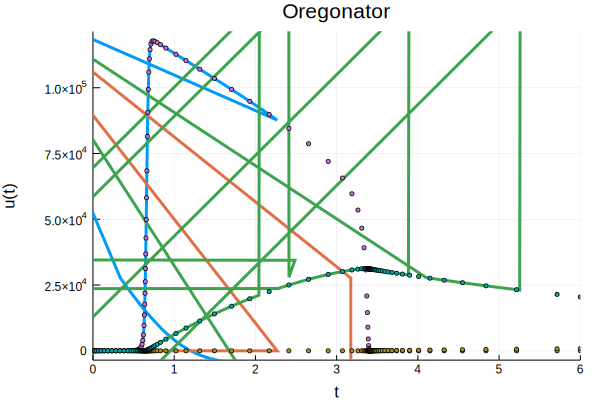

In [3]:
using Plots
plot(u)
scatter!(u.t,u[:,:]',m=2,xaxis=("t"),yaxis=("u(t)"),
    title="Oregonator",leg=:none)

In [4]:
@show num_steps_stiff = length(u.t); 

num_steps_stiff = length(u.t) = 107


You can see that the stiff solver takes small time steps only when some part of the solution is changing rapidly. However, a nonstiff solver, based on an explicit method, is much slower and takes a lot more steps.

In [5]:
@elapsed u = solve(IVP,DP5())  # select DP5 solver

2.184417727

In [6]:
@show num_steps_nonstiff = length(u.t);

num_steps_nonstiff = length(u.t) = 28512


Here is the Jacobian matrix at any value of $\mathbf{u}$. 

In [7]:
q,s,w = (8.375e-6,77.27,0.161)
J = u -> [ -s*(u[2]+1-2*q*u[1]) s*(1-u[1]) 0; 
    -u[2]/s (-1-u[1])/s 1/s; 
    w 0 -w];

During the early phase, the time steps seem fairly large. The eigenvalues around $t=1/2$ are 

In [8]:
t = u.t
i1 = findfirst(@.t>0.5) 
using LinearAlgebra
lambda1 = eigvals( J(u[:,i1]) )

3-element Array{Float64,1}:
 -131.13742993372898  
   -3.3910437818666472
   -0.3394987956128886

These are real and negative. Checking the stability region of RK4 along the negative real axis, we see that stability requires a maximum time step

In [9]:
maxstep1 = 2.8 / maximum(abs.(lambda1))

0.021351646142638264

The actual step size chosen by the solver was comparable:

In [10]:
step1 = t[i1+1] - t[i1]

0.031366886495779234

Later in the simulation, the steps seem quite small compared to the apparent rate of activity. We look near $t=4$:

In [11]:
i2 = findfirst(@.t>4)   
lambda2 = eigvals( J(u[:,i2]) )

3-element Array{Float64,1}:
 -18238.851056969022      
     -0.025883880781886193
     -0.16099966593810738 

These are also real and negative. We compare the maximum and observed step sizes again:

In [12]:
@show maxstep2 = 2.8 / maximum(abs.(lambda2));
@show step2 = t[i2+1] - t[i2];

maxstep2 = 2.8 / maximum(abs.(lambda2)) = 0.00015351844210220283
step2 = t[i2 + 1] - t[i2] = 0.00018281251555229971


Again, the eigenvalues give a good indication of how the steps are being chosen, at least to order of magnitude.